In [3]:
%matplotlib inline

Comparison of training a hardware efficient ansatz with a global cost function and the gadget equivalent

Necessary imports

In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import datetime

from gadget_gradients_utils import hardware_efficient_ansatz, cat_state_preparation
from gadget_training_utils import *

np.random.seed(42)
data_folder = '../../results/data/training/'
save_data = False

Defining the relevant parameters of the simulation

In [5]:
computational_qubits = 6
ancillary_qubits = 6
num_layers = 2
max_iter = 100
# num_samples = 200
perturbation_factor = 0.5
locality = computational_qubits
lambda_max = (locality - 1) / (4 * locality)
gate_set = [qml.RX, qml.RY, qml.RZ]

Global cost function
--------

Creating the quantum device with the right number of qubits and choosing an optimizer

In [6]:
dev_comp = qml.device("default.qubit", wires=range(computational_qubits))
opt = qml.GradientDescentOptimizer(stepsize=0.1)

Initializing the parameters

In [7]:
weights_init = np.random.uniform(0, np.pi, size=(num_layers, computational_qubits), requires_grad=True)
random_gate_sequence = [[np.random.choice(gate_set) for _ in range(computational_qubits)] for _ in range(num_layers)]
cost_computational = [computational_cost_function(weights_init, random_gate_sequence, computational_qubits, dev_comp)]

Optimization loop

In [8]:
weights = weights_init
for it in range(max_iter):
    # /!\ keyword arguments are not trained? don't know why but don't remove the 'computational_qubits='
    # keyword arguments are not wrapped https://discuss.pennylane.ai/t/wire-error-on-ibm-simulator/1282
    weights = opt.step(computational_cost_function, weights, gate_sequence=random_gate_sequence, computational_qubits=computational_qubits, device=dev_comp)
    cost_computational.append(computational_cost_function(weights, random_gate_sequence, computational_qubits, dev_comp))
    # opt.update_stepsize(stepsize)
    if it % 50 == 0:
        print("Iteration = {:5d} | Cost function = {: .8f}".format(it+1, cost_computational[-1]))


Iteration =     1 | Cost function =  0.07633306
Iteration =    51 | Cost function = -0.91657542


Saving and plotting the results

In [9]:
if save_data: 
    with open(data_folder + '{}_training_global_{}qubits_{}layers_{}iterations.dat'
                .format(datetime.datetime.now().strftime("%y%m%d"),
                        computational_qubits, num_layers, max_iter), 'w') as of:
        of.write('# iteration\tcost\n')

        for it in range(max_iter+1):
            of.write('{}\t{}\n'.format(it, cost_computational[it]))

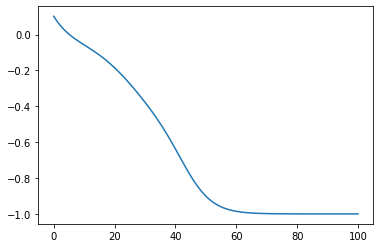

In [10]:
plt.plot(np.arange(max_iter+1), cost_computational)
plt.show()

Local cost function
--------

In [13]:
def local_cost_function(params, gate_sequence, computational_qubits, device):
    gadget_qnode = qml.QNode(gadget_circuit, device)
    Hloc = qml.PauliZ(0) @ qml.PauliZ(1)
    return gadget_qnode(params, gate_sequence, computational_qubits, Hloc)

In [14]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

In [16]:
weights_init = np.random.uniform(0, np.pi, size=(num_layers, computational_qubits), requires_grad=True)
random_gate_sequence = [[np.random.choice(gate_set) for _ in range(computational_qubits)] for _ in range(num_layers)]
cost_local = [local_cost_function(weights_init, random_gate_sequence, computational_qubits, dev_comp)]

In [17]:
weights = weights_init
for it in range(max_iter):
    weights = opt.step(local_cost_function, weights, gate_sequence=random_gate_sequence, computational_qubits=computational_qubits, device=dev_comp)
    cost_local.append(local_cost_function(weights, random_gate_sequence, computational_qubits, dev_comp))
    if it % 50 == 0:
        print("Iteration = {:5d} | Cost function = {: .8f}".format(it+1, cost_local[-1]))


Iteration =     1 | Cost function =  0.10371227
Iteration =    51 | Cost function = -0.99734120


In [18]:
if save_data:
    with open(data_folder + '{}_training_local_{}qubits_{}layers_{}iterations.dat'
                .format(datetime.datetime.now().strftime("%y%m%d"),
                        computational_qubits, num_layers, max_iter), 'w') as of:
        of.write('# iteration\tcost\n')

        for it in range(max_iter+1):
            of.write('{}\t{}\n'.format(it, cost_local[it]))

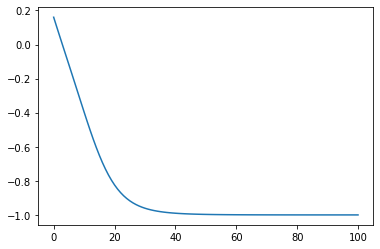

In [19]:
plt.plot(np.arange(max_iter+1), cost_local)
plt.show()

Gadget cost function
--------

In [22]:
dev_gad = qml.device("default.qubit", wires=range(computational_qubits+ancillary_qubits))
opt = qml.GradientDescentOptimizer(stepsize=0.4)
l = perturbation_factor * lambda_max

In [23]:
# weights_init = np.zeros((num_layers, computational_qubits+ancillary_qubits), requires_grad=True)           # starting close to the ground state
weights_init = 0.2 * np.random.uniform(0, np.pi, size=(num_layers, computational_qubits+ancillary_qubits), requires_grad=True)
random_gate_sequence = [[np.random.choice(gate_set) for _ in range(computational_qubits+ancillary_qubits)] for _ in range(num_layers)]
cost_computational = [computational_cost_function(weights_init, random_gate_sequence, computational_qubits, dev_gad)]
cost_gadget = [gadget_cost_function(weights_init, random_gate_sequence, computational_qubits, dev_gad, l)]
cost_ancillary = [ancillary_cost_function(weights_init, random_gate_sequence, computational_qubits, dev_gad)]
cost_perturbation = [perturbation_cost_function(weights_init, random_gate_sequence, computational_qubits, dev_gad)]
print(cost_gadget[0])
print(cost_computational[0])


0.5736447636368842
-0.45003679290792825


In [24]:
weights = weights_init
for it in range(max_iter):
    weights, prev_cost = opt.step_and_cost(gadget_cost_function, weights, gate_sequence=random_gate_sequence, computational_qubits=computational_qubits, device=dev_gad, lambda_value=l)
    cost_computational.append(computational_cost_function(weights, random_gate_sequence, computational_qubits, dev_gad))
    cost_gadget.append(gadget_cost_function(weights, random_gate_sequence, computational_qubits, dev_gad, l))
    cost_ancillary.append(ancillary_cost_function(weights, random_gate_sequence, computational_qubits, dev_gad))
    cost_perturbation.append(perturbation_cost_function(weights, random_gate_sequence, computational_qubits, dev_gad))
    # opt.update_stepsize(stepsize)
    if it % 10 == 0:
        print(f"Iteration = {it:5d} | " +
               "Gadget cost = {:.8f} | ".format(cost_gadget[-1]) +
               "Computational cost = {:.8f}".format(cost_computational[-1]))


Iteration =     0 | Gadget cost = 0.00246536 | Computational cost = -0.45003679
Iteration =    10 | Gadget cost = 0.00000000 | Computational cost = -0.45003679
Iteration =    20 | Gadget cost = 0.00000000 | Computational cost = -0.45003679
Iteration =    30 | Gadget cost = 0.00000000 | Computational cost = -0.45003679
Iteration =    40 | Gadget cost = 0.00000000 | Computational cost = -0.45003679
Iteration =    50 | Gadget cost = 0.00000000 | Computational cost = -0.45003679
Iteration =    60 | Gadget cost = 0.00000000 | Computational cost = -0.45003679
Iteration =    70 | Gadget cost = 0.00000000 | Computational cost = -0.45003679
Iteration =    80 | Gadget cost = 0.00000000 | Computational cost = -0.45003679
Iteration =    90 | Gadget cost = 0.00000000 | Computational cost = -0.45003679


In [25]:
if save_data:
    with open(data_folder + '{}_training_gadget_{}qubits_{}layers_{}iterations_{}lambda.dat'
                .format(datetime.datetime.now().strftime("%y%m%d"),
                        computational_qubits, num_layers, max_iter, perturbation_factor), 'w') as of:
        of.write('# iteration\tcost gadget\tcost computational\t cost ancillary \tcost perturbation\n')

        for it in range(max_iter+1):
            of.write('{}\t{}\t{}\t{}\t{}\n'.format(it, cost_gadget[it], cost_computational[it], cost_ancillary[it], cost_perturbation[it]))

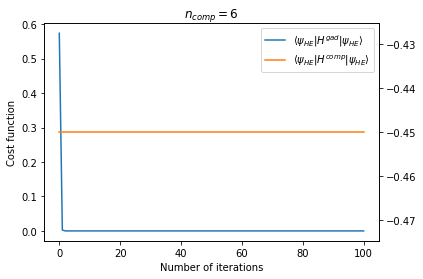

In [26]:
fig, ax = plt.subplots()
ax2 = ax.twinx() 
p_gad, = ax.plot(np.arange(max_iter+1), cost_gadget, c='tab:blue', label=r'$\langle \psi_{HE}| H^{gad} |\psi_{HE} \rangle$')
p_comp, = ax2.plot(np.arange(max_iter+1), cost_computational, c='tab:orange', label=r'$\langle \psi_{HE}| H^{comp} |\psi_{HE} \rangle$')
p = [p_gad, p_comp]
ax.set_xlabel(r"Number of iterations")
ax.set_ylabel(r"Cost function")
ax.legend(p, [p_.get_label() for p_ in p])
ax.set_title(r"$n_{comp}=$"+"{}".format(computational_qubits))
plt.show()